# 1. Install deep learning libraries.
This usually takes less than 5 minutes on A100. Hit restart session before running the next code, and run it again.

In [1]:
!pip install torch torchvision
!pip install transformers
!pip install groundingdino
!pip install matplotlib pillow
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-psbqb2iy
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-psbqb2iy
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit f4ca2960a97cb73aff2c459a9d0f06c7674452e4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-cnyck8dj/groundingdino_c8c0167614a94675b11e12f7cc0da6b7
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-cnyck8dj/groundingdino_c8c0167614a94675b11e12f7cc0da6b7
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit c023468fafeb0933d06aa8ba49d96089ce9a6af3
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fac

#2. Import required Python libraries.

In [2]:
import os
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from PIL import Image, ImageOps, ImageDraw
from lang_sam import LangSAM
import cv2
import torch

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#3. Check GPU availability and set the device for CUDA.
No need to do it if connected to A100 or V100 - or running this notebook on Jupyter or Colab.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#4. Load SAM and DINO models.

In [3]:
model = LangSAM()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:13<00:00, 196MB/s]


#5. Define functions.

In [157]:
def split_image(image):
    width, height = image.size
    left_half = image.crop((0, 0, width // 2, height))
    right_half = image.crop((width // 2, 0, width, height))
    return left_half, right_half

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def save_masks_on_original(image_size, masks, positions, filename):
    # Create a new black image with the same size as the original
    mask_image = Image.new('L', image_size, 0)

    # Go through each mask and its position
    for mask, position in zip(masks, positions):
        # Convert the mask to a PIL image
        mask_pil = Image.fromarray((mask * 255).astype(np.uint8), 'L')
        # Paste the mask onto the black image at the given position
        mask_image.paste(mask_pil, position, mask_pil)

    # Save the result
    mask_image.save(filename)

def display_image_with_masks(image, left_masks, right_masks):
    num_left_masks = len(left_masks)
    num_right_masks = len(right_masks)

    fig, axes = plt.subplots(2, max(num_left_masks, num_right_masks) + 1, figsize=(15, 10))

    # Plot the original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')

    # Plot the left masks
    for i in range(num_left_masks):
        axes[0, i+1].imshow(left_masks[i], cmap='Blues')
        axes[0, i+1].set_title(f"Left Mask {i+1}")
        axes[0, i+1].axis('off')

    # Plot the right masks
    for i in range(num_right_masks):
        axes[1, i+1].imshow(right_masks[i], cmap='Reds')
        axes[1, i+1].set_title(f"Right Mask {i+1}")
        axes[1, i+1].axis('off')

    # Remove any unused subplots
    for i in range(num_left_masks, max(num_left_masks, num_right_masks)):
        axes[0, i+1].axis('off')
    for i in range(num_right_masks, max(num_left_masks, num_right_masks)):
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, left_boxes, right_boxes, left_logits, right_logits):
    combined_boxes = [(box, 'left') for box in left_boxes] + [(box, 'right') for box in right_boxes]
    centerline = image.size[0] // 2
    plotline = image.size[1] // 2
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    centroidsL = [] #Left side window centroids.
    centroidsR = [] #Right side window centroids.

    tolerance = 20

    ccL = [] #Closest left window centroid to the adjacency line.
    ccR = [] #Closest right window centroid to the adjacency line.

    lW = []
    rW = []
    rowR = []
    rowL = []

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        box_width = x_max - x_min
        box_height = y_max - y_min
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        centroidsL.append((centroid_x, centroid_y))
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='blue', linewidth=1)
        ax.plot(centroid_x, centroid_y, 'o', color='blue', markersize=3)
        ax.add_patch(rect)

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min += centerline
        x_max += centerline
        box_width = x_max - x_min
        box_height = y_max - y_min
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        centroidsR.append((centroid_x, centroid_y))
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=1)
        ax.plot(centroid_x, centroid_y, 'o', color='red', markersize=3)
        ax.add_patch(rect)

    ccL = min(centroidsL, key=lambda c: abs(c[0] - centerline)) if centroidsL else None
    if ccL:
        ax.axvline(ccL[0], color='blue', linestyle='--')

    ccR = min(centroidsR, key=lambda c: abs(c[0] - centerline)) if centroidsR else None
    if ccR:
        ax.axvline(ccR[0], color='red', linestyle='--')

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        x_min_tol = x_min - tolerance
        x_max_tol = x_max + tolerance
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        if x_min_tol <= ccL[0] <= x_max_tol:
            rowL.append((x_min, y_min, x_max - x_min, y_max - y_min, centroid_x, centroid_y, (centroid_y - plotline)))
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='lime', linewidth=5)
            ax.add_patch(rect)

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min_tol = x_min - tolerance
        x_max_tol = x_max + tolerance
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        if x_min <= ccR[0] <= x_max:
            rowR.append((x_min, y_min, x_max - x_min, y_max - y_min, centroid_x, centroid_y, (centroid_y - plotline)))
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='lime', linewidth=5)
            ax.add_patch(rect)

    left_windows = sorted(rowL, key=lambda c: c[5], reverse=True)
    right_windows = sorted(rowR, key=lambda c: c[5], reverse=True)
    lwIndex = [(window[0], window[1], window[2], window[3], window[4], window[5], window[6], f'L{i+1}') for i, window in enumerate(left_windows)]
    rwIndex = [(window[0], window[1], window[2], window[3], window[4], window[5], window[6], f'R{i+1}') for i, window in enumerate(right_windows)]

    for window in lwIndex:
        ax.text(window[4], window[5], window[7], color='black', fontsize=8, ha='center', va='center')

    for window in rwIndex:
        ax.text(window[4], window[5], window[7], color='black', fontsize=8, ha='center', va='center')

    lwIndex_sorted_by_distance = sorted(lwIndex, key=lambda w: abs(w[6]))
    rwIndex_sorted_by_distance = sorted(rwIndex, key=lambda w: abs(w[6]))
    two_closest_lw = lwIndex_sorted_by_distance[:2]
    two_closest_rw = rwIndex_sorted_by_distance[:2]

    for window in lwIndex_sorted_by_distance[:2]:
        rect = plt.Rectangle((window[0], window[1]), window[2], window[3], fill=False, edgecolor='yellow', linewidth=10)
        ax.axhline(window[5], color='yellow', linestyle='--')
        ax.add_patch(rect)

    for window in rwIndex_sorted_by_distance[:2]:
        rect = plt.Rectangle((window[0], window[1]), window[2], window[3], fill=False, edgecolor='yellow', linewidth=10)
        ax.axhline(window[5], color='yellow', linestyle='--')
        ax.add_patch(rect)

    def draw_lines_and_get_midpoints(left_closest_windows, right_closest_windows, color, ax, centerline):
        midpoints = []  # To store the midpoint coordinates
        y_distances = []  # This will now store actual y-distance values, not lists

        # Loop over both sets of windows
        for closest_windows in [left_closest_windows, right_closest_windows]:
            if len(closest_windows) == 2:  # Ensure there are at least two windows to connect.
                # Extract centroids of the two closest windows
                centroid1 = (closest_windows[0][4], closest_windows[0][5])
                centroid2 = (closest_windows[1][4], closest_windows[1][5])

                # Draw a line between the centroids
                ax.plot([centroid1[0], centroid2[0]], [centroid1[1], centroid2[1]], color=color)
                midpoint_x = (centroid1[0] + centroid2[0]) / 2
                midpoint_y = (centroid1[1] + centroid2[1]) / 2

                # Optionally, mark the midpoint on the plot
                ax.plot(midpoint_x, midpoint_y, 'o', color=color, markersize=10)

                # Append the midpoint coordinates to the list
                midpoints.append((midpoint_x, midpoint_y))

        # Ensure you have two midpoints before calculating the distance between them
        if len(midpoints) == 2:
            mdist = abs(midpoints[0][1] - midpoints[1][1])

            # Since you're working with a list, ensure you're calculating y_dist properly
            # Let's just use mdist for comparison logic since the y_distance calculation was not clear
            if mdist >= 0.75:
                ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='red', markersize=10)
            elif mdist > 0.33:
                ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='orange', markersize=10)
            else:
                ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='green', markersize=10)

    draw_lines_and_get_midpoints(two_closest_lw, two_closest_rw, 'red', ax, centerline)

    plt.show()

def display_combined_masks(image, left_masks, right_masks):
    # Create an empty RGBA image for the full overlay
    full_overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))

    # Process left masks
    for mask in left_masks:
        # Convert the mask to an RGBA image
        mask_image = Image.fromarray((mask * 255).astype('uint8'))
        mask_rgba = ImageOps.colorize(mask_image.convert('L'), (0, 0, 255), (0, 0, 255))
        mask_rgba.putalpha(Image.fromarray((mask * 128).astype('uint8')))  # Apply transparency

        # Paste the mask onto the full overlay
        full_overlay.paste(mask_rgba, (0, 0), mask_rgba)

    # Process right masks
    for mask in right_masks:
        # Convert the mask to an RGBA image
        mask_image = Image.fromarray((mask * 255).astype('uint8'))
        mask_rgba = ImageOps.colorize(mask_image.convert('L'), (255, 0, 0), (255, 0, 0))
        mask_rgba.putalpha(Image.fromarray((mask * 128).astype('uint8')))  # Apply transparency

        # Calculate the offset for pasting the right mask
        right_offset = (image.size[0] - mask_rgba.size[0], 0)

        # Paste the mask onto the full overlay
        full_overlay.paste(mask_rgba, right_offset, mask_rgba)

    # Display the original image with overlays
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Combined Masks - Transparent")
    ax.axis('off')

    # Overlay the combined masks on top of the original image
    combined = Image.alpha_composite(image.convert("RGBA"), full_overlay)
    ax.imshow(combined)

    plt.show()

def display_masks_for_each_side(image, left_masks, right_masks):
    image_width, image_height = image.size

    # Create a full-width overlay
    full_overlay = np.zeros((image_height, image_width, 4))

    # Draw on the overlay using PIL for centroids
    draw = ImageDraw.Draw(Image.fromarray((full_overlay * 255).astype('uint8'), 'RGBA'))

    # Helper function to draw and return centroids
    def process_masks(masks, overlay, color, draw):
        centroids = []
        for mask in masks:
            mask_height, mask_width = mask.shape
            mask_overlay = np.zeros((image_height, mask_width, 4))
            mask_overlay[mask > 0, :3] = color[:3]  # Color for masks
            mask_overlay[mask > 0, 3] = color[3]  # Transparency

            # Calculate the centroid for the current mask
            y_indices, x_indices = np.where(mask > 0)
            centroid_x = int(x_indices.mean())
            centroid_y = int(y_indices.mean())
            centroids.append((centroid_x, centroid_y))

            # Draw the centroid for the current mask
            draw.ellipse((centroid_x - 3, centroid_y - 3, centroid_x + 3, centroid_y + 3), fill=tuple(color[:3]))

            # Combine the current mask with the overall overlay
            overlay = np.maximum(overlay, mask_overlay)

        return overlay, centroids

    # Process left masks
    full_overlay[:, :image_width // 2], left_centroids = process_masks(left_masks, full_overlay[:, :image_width // 2], [0, 0, 1, 0.5], draw)

    # Process right masks
    full_overlay[:, image_width // 2:], right_centroids = process_masks(right_masks, full_overlay[:, image_width // 2:], [1, 0, 0, 0.5], draw)

    # Display the original image with overlays
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Combined Masks with Centroids")
    ax.axis('off')
    ax.imshow(full_overlay, interpolation='nearest')

    plt.show()

    return left_centroids, right_centroids

def display_masks_with_detected_corners_debug(image, left_masks, right_masks):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Segmented Windows with Detected Polygon Corners")
    ax.axis('off')

    def find_and_plot_corners(mask, color, offset=(0, 0), mask_side=""):
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        mask_uint8 = (mask * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            epsilon = 0.05 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            if len(approx) == 4:
                corners = [corner.ravel() + np.array(offset) for corner in approx]
#               print(f"{mask_side} Mask Approximated Corners: {corners}")
                for corner in corners:
                    ax.plot(corner[0], corner[1], marker='o', markersize=3, color=color)

                centroid = np.mean(corners, axis=0)
                ax.plot(centroid[0], centroid[1], marker='x', markersize=7, color=color)
#               print(f"{mask_side} Mask Centroid: {centroid}")

    # Process left masks
    for i, mask in enumerate(left_masks):
        find_and_plot_corners(mask, color='blue', mask_side=f"Left {i+1}")

    # Process right masks
    for i, mask in enumerate(right_masks):
        right_offset = (image.size[0] - mask.shape[1], 0)
        find_and_plot_corners(mask, color='red', offset=right_offset, mask_side=f"Right {i+1}")

    plt.show()

#6. Define image segmentation function.

In [127]:
def process_image(image_path, text_prompt, model):
    try:
        image_pil = Image.open(image_path).convert("RGB")
        image_size = image_pil.size
        left_half, right_half = split_image(image_pil)
        left_masks, left_boxes, left_phrases, left_logits = model.predict(left_half, text_prompt)
        right_masks, right_boxes, right_phrases, right_logits = model.predict(right_half, text_prompt)
        left_positions = [(0, 0)] * len(left_masks)
        right_positions = [(image_size[0] // 2, 0)] * len(right_masks)

        if len(left_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the left half of the image.")
        else:
            left_masks_np = [mask.squeeze().cpu().numpy() for mask in left_masks]
#            for i, mask_np in enumerate(left_masks_np):
#                mask_path_bw = f"/content/drive/MyDrive/FaultLines/original/left_mask_bw_{i+1}.png"
#                save_mask(mask_np, mask_path_bw)

        if len(right_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the right half of the image.")
        else:
            right_masks_np = [mask.squeeze().cpu().numpy() for mask in right_masks]
#            for i, mask_np in enumerate(right_masks_np):
#                mask_path = f"/content/drive/MyDrive/FaultLines/original/right_mask_bw_{i+1}.png"
#                save_mask(mask_np, mask_path)

        # Combine left and right masks and positions
        display_image_with_masks(image_pil, left_masks_np, right_masks_np)
        display_image_with_boxes(image_pil, left_boxes, right_boxes, left_logits, right_logits)
        display_combined_masks(image_pil, left_masks_np, right_masks_np)
        display_masks_for_each_side(image_pil, left_masks, right_masks)
        display_masks_with_detected_corners_debug(image_pil, left_masks, right_masks)


    except IOError as e:
        print(f"Error processing image {image_path}: {e}")

#7. Define main model, and add image paths.

In [149]:
def main(model):
    warnings.filterwarnings("ignore")

    image_paths = [
        "/content/sample_data/5.png",
    ]
    text_prompt = "window"

    for image_path in image_paths:
        process_image(image_path, text_prompt, model)

#8. Run.

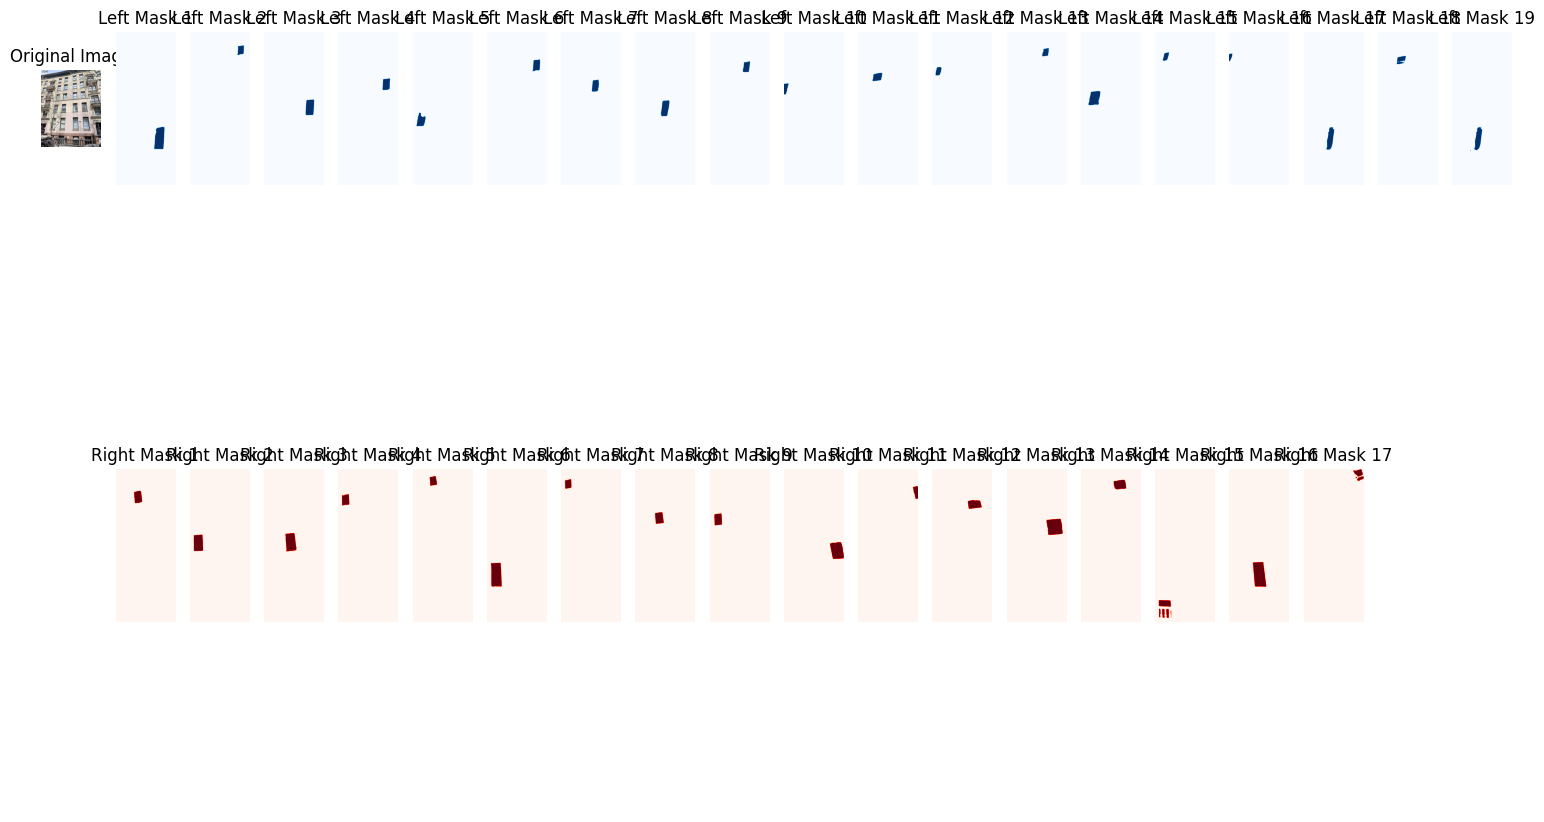

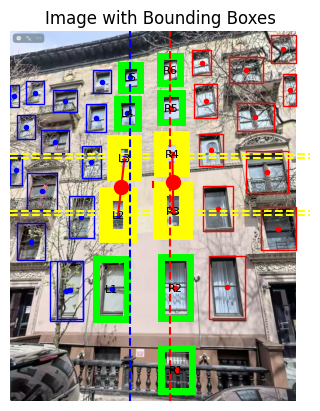

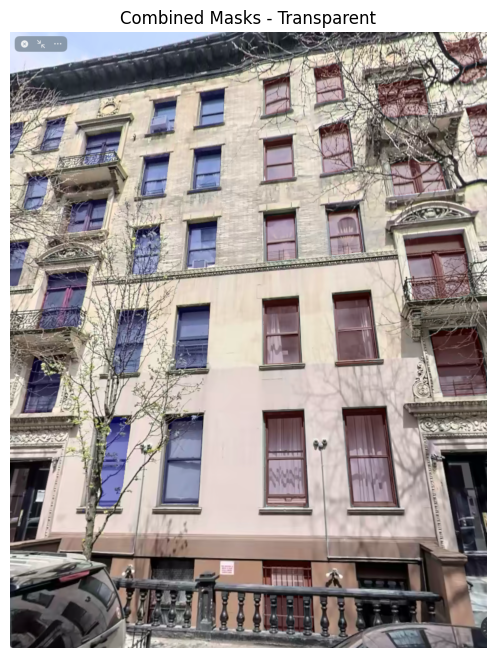

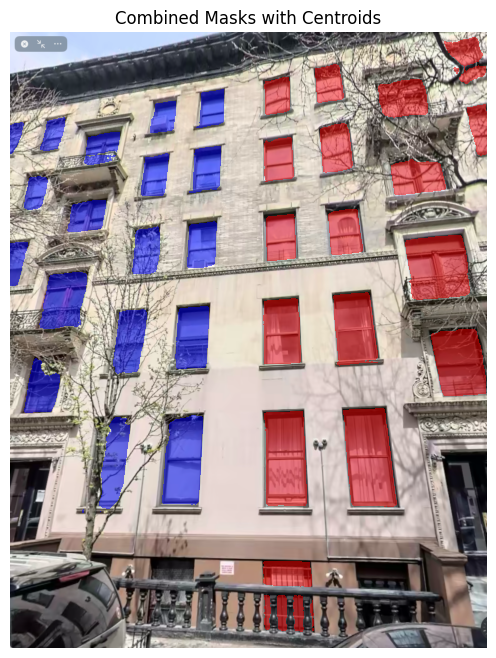

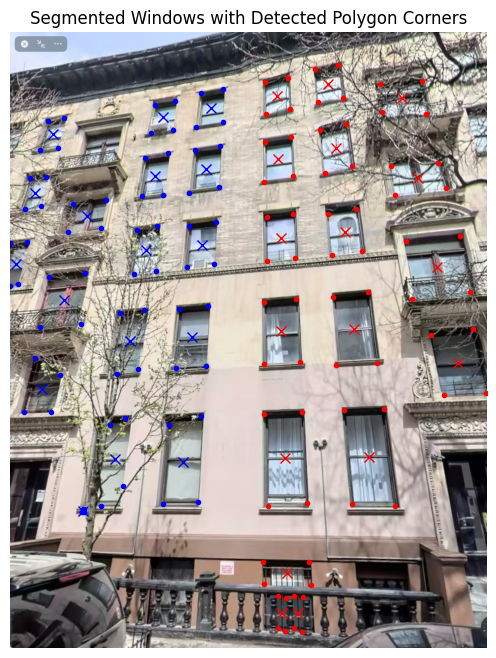

In [158]:
if __name__ == "__main__":
    main(model)